In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

import numpy as np 
import matplotlib.pyplot as plt

import emcee
import corner
from emcee.utils import MPIPool

from astropy.table import Table, Column
from astropy.cosmology import FlatLambdaCDM

from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import delta_sigma
from halotools.mock_observables import tpcf
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
from halotools.utils import crossmatch

# UniverseMachine Python IO
from umachine_pyio.load_mock import load_mock_from_binaries, value_added_mock

# From this repo
from stellar_mass_function import compute_smf, \
    bootstrap_smf
from model_predictions import total_stellar_mass_including_satellites, \
    precompute_lensing_pairs
from full_mass_profile_model import sm_profile_from_mhalo
from swot_weak_lensing import SwotWL
from forward_model import UMMassProfModel

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

## Test: Load the UM Mock catalog

In [4]:
kwargs = {'um_cat' : 'UM_bolshoi_mock_value_added.fits',
          'um_wlcat' : 'bolplanck_rockstar_halotools_v0p4_z0.0_precompute_20bins.npz',
          'obs_wl_sample' : 's16a_m100_m10_boxbin',
          'obs_smf_inn' : 's16a_massive_fastlane_logm10_smf_default.fits',
          'obs_smf_tot' : 's16a_massive_fastlane_logm100_smf_default.fits',
         }
#kwargs = {'um_min_mvir' : 11.5}

um = UMMassProfModel(verbose=True, **kwargs)

print(um.um_mock.colnames)

# Input stellar mass catalog: s16a_wide_massive_fastlane_short_170610.fits
# Input weak lensing profile sample: s16a_m100_m10_boxbin
# There are 19 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: s16a_massive_fastlane_logm10_smf_default.fits
# Pre-computed SMF for total logMs: s16a_massive_fastlane_logm100_smf_default.fits
# The volume of the HSC data is     80672371.33 Mpc^3
# Using logm_10 as proxy of inner stellar mass.
# Using logm_100 as proxy of total stellar mass.
# For inner stellar mass: 
    16 bins at 10.40 < logMinn < 12.00
# For total stellar mass: 
    10 bins at 11.60 < logMtot < 12.20
# The volume of the UniverseMachine mock is     45553935.86 Mpc^3
['obs_sfr', 'icl', 'upid', 'sfr', 'halo_id', 'mpeak', 'y', 'sm', 'mvir', 'x', 'z', 'obs_sm', 'halo_hostid', 'host_halo_mvir', 'mask_central', 'mtot_galaxy', 'mstar_mhalo', 'logms_gal', 'logms_icl', 'logms_tot', 'logms_halo', 'logmh_vir', 'logmh_peak', 'mhalo_host', 'logmh_host']


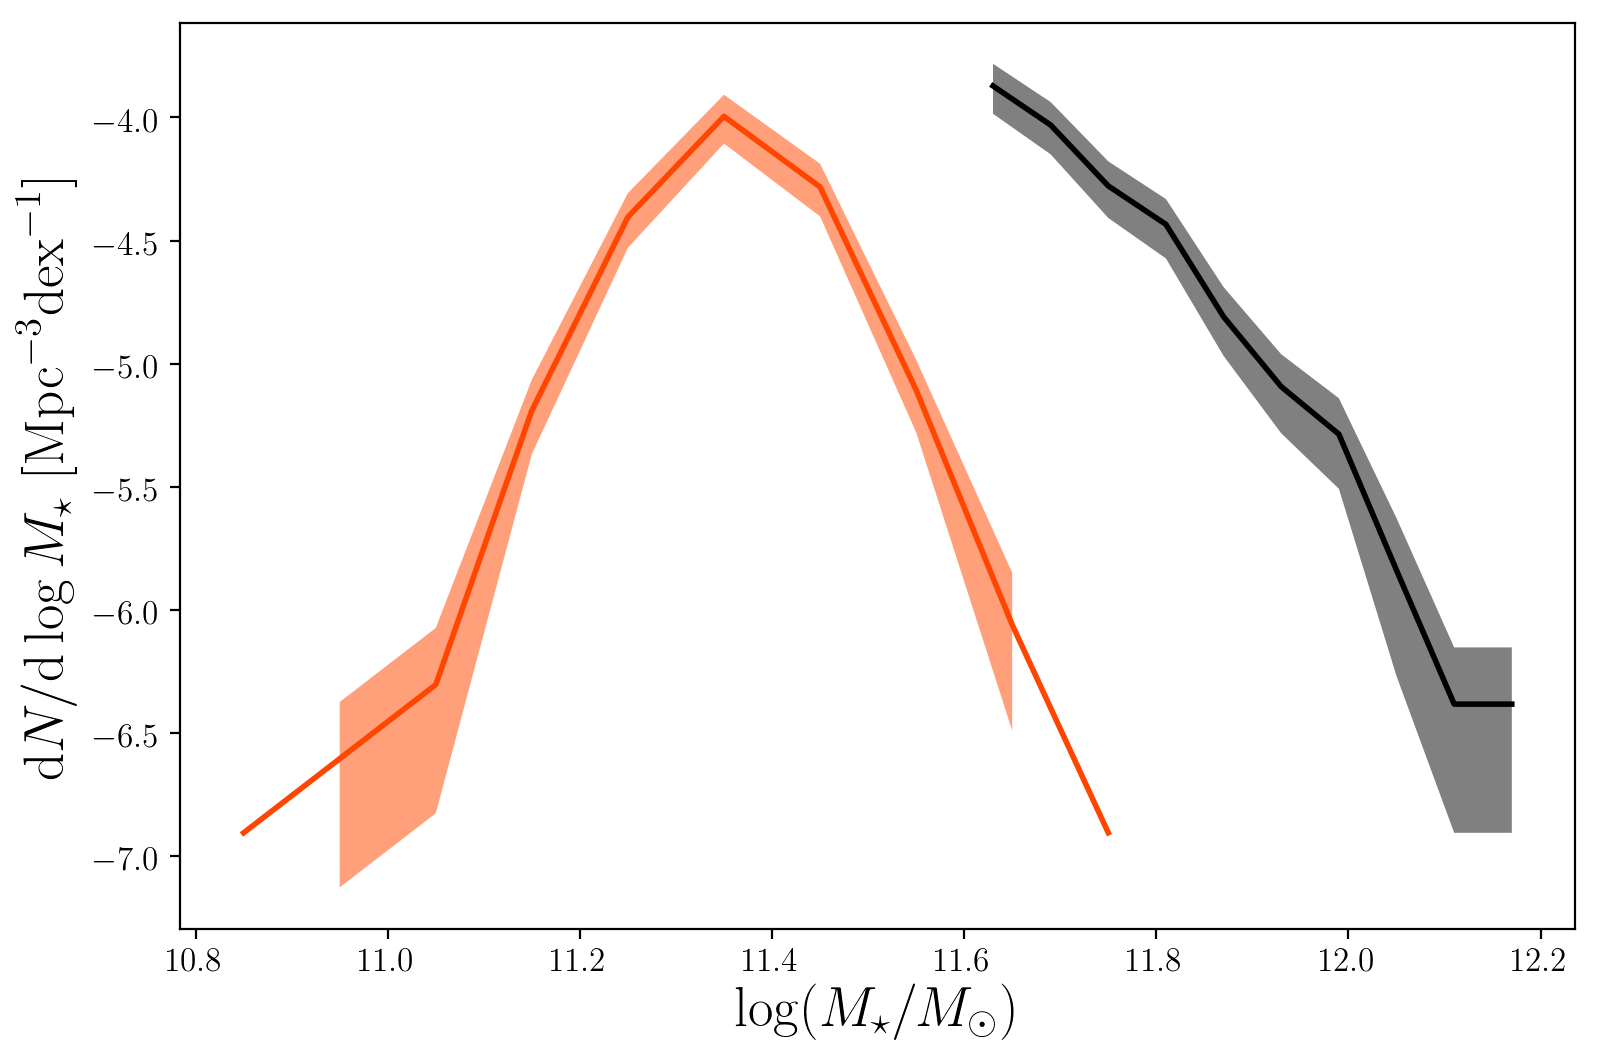

In [4]:
a = um.showObsSMF()

## Observed stellar mass function

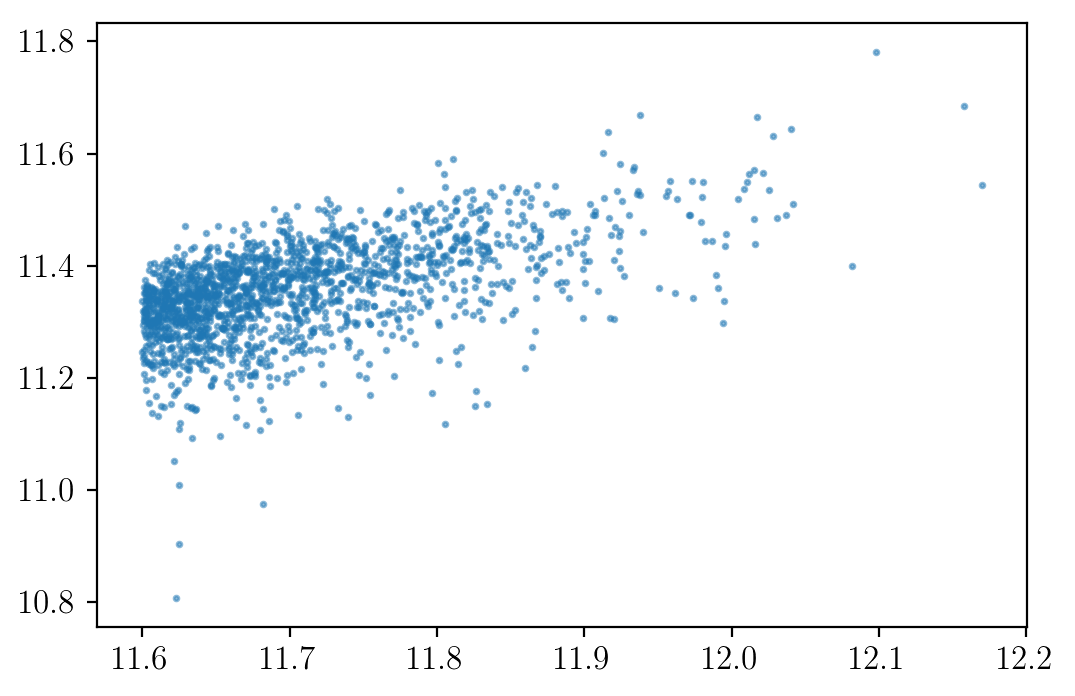

In [3]:
obs_m10, obs_m100 = um.loadObsMass()

plt.scatter(obs_m100, obs_m10, s=3, alpha=0.5)

In [75]:
m10_smf = um.computeSMF(obs_m10, um.obs_volume, 16, 10.4, 12.0, 
                        add_err=0.2, n_boots=10000)

m100_smf = um.computeSMF(obs_m100, um.obs_volume, 10, 11.6, 12.2, 
                         add_err=0.2, n_boots=10000)

In [76]:
m10_smf

logm_mean,logm_0,logm_1,smf,smf_err,smf_low,smf_upp
float64,float64,float64,float64,float64,float64,float64
10.45,10.4,10.5,0.0,0.0,0.0,0.0
10.55,10.5,10.6,0.0,0.0,0.0,0.0
10.65,10.6,10.7,0.0,0.0,0.0,0.0
10.75,10.7,10.8,0.0,0.0,0.0,0.0
10.85,10.8,10.9,1.23958175957e-07,2.48352780074e-08,-2.47916351914e-08,2.72707987105e-07
10.95,10.9,11.0,2.47916351914e-07,4.96449906451e-08,7.43749055741e-08,4.21457798253e-07
11.05,11.0,11.1,4.95832703827e-07,9.92538263975e-08,1.48749811148e-07,8.42915596506e-07
11.15,11.1,11.2,6.44582514975e-06,1.28947974277e-06,4.28895288811e-06,8.6026974114e-06
11.25,11.2,11.3,3.94186999543e-05,7.88451825375e-06,2.95516291481e-05,4.92857707604e-05


In [77]:
m100_smf

logm_mean,logm_0,logm_1,smf,smf_err,smf_low,smf_upp
float64,float64,float64,float64,float64,float64,float64
11.63,11.6,11.66,0.000134288023953,2.68599988922e-05,0.000103505076924,0.000165277567942
11.69,11.66,11.72,9.31752289275e-05,1.86370400105e-05,7.08214378633e-05,0.000115529019992
11.75,11.72,11.78,5.26822247816e-05,1.05379444892e-05,3.90468254264e-05,6.63176241369e-05
11.81,11.78,11.84,3.67742588672e-05,7.35610461425e-06,2.67336466147e-05,4.66082741598e-05
11.87,11.84,11.9,1.54947719946e-05,3.09976763478e-06,1.07430419163e-05,2.04530990329e-05
11.93,11.9,11.96,8.05728143719e-06,1.61204272016e-06,5.20624339019e-06,1.09083194842e-05
11.99,11.96,12.02,5.1649239982e-06,1.03345432158e-06,3.09895439892e-06,7.23089359748e-06
12.05,12.02,12.08,1.4461787195e-06,2.89484191559e-07,5.37152095813e-07,2.35520534318e-06
12.11,12.08,12.14,4.13193919856e-07,8.27715848313e-08,1.23958175957e-07,7.02429663755e-07


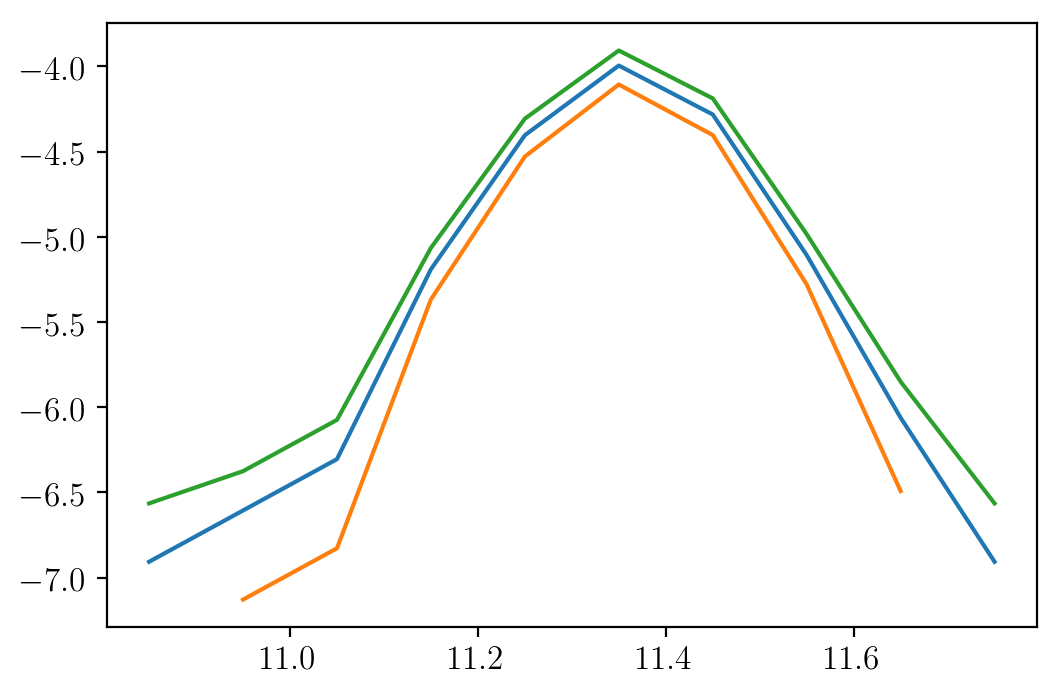

In [51]:
plt.plot(m10_smf['logm_mean'], np.log10(m10_smf['smf']))
plt.plot(m10_smf['logm_mean'], np.log10(m10_smf['smf_low']))
plt.plot(m10_smf['logm_mean'], np.log10(m10_smf['smf_upp']))

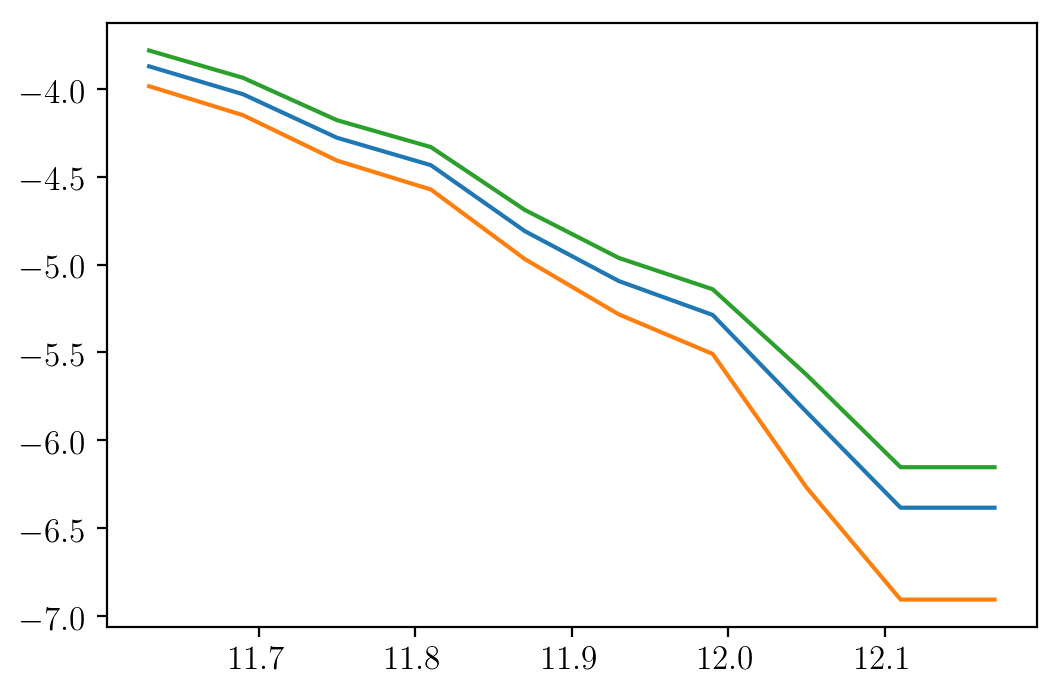

In [78]:
plt.plot(m100_smf['logm_mean'], np.log10(m100_smf['smf']))
plt.plot(m100_smf['logm_mean'], np.log10(m100_smf['smf_low']))
plt.plot(m100_smf['logm_mean'], np.log10(m100_smf['smf_upp']))

In [79]:
m10_smf.write(os.path.join(
    um.obs_dir, 's16a_massive_fastlane_logm10_smf_default.fits'),
    format='fits', overwrite=True
    )

m100_smf.write(os.path.join(
    um.obs_dir, 's16a_massive_fastlane_logm100_smf_default.fits'),
    format='fits', overwrite=True
    )

## Observed WL profiles

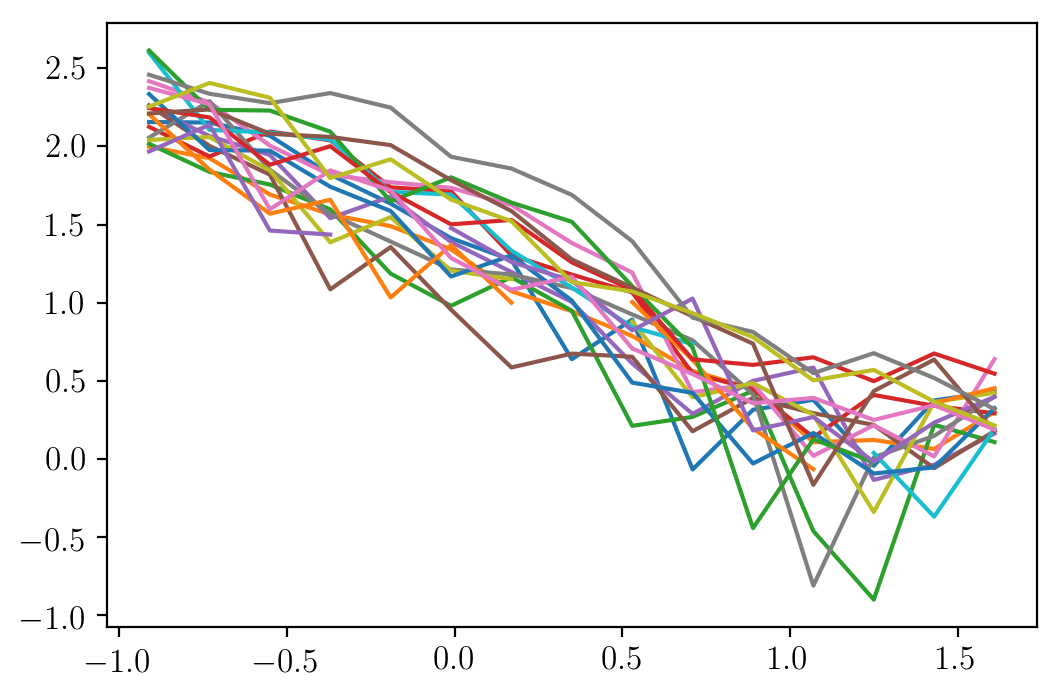

In [49]:
for prof in um.obs_wl_profs:
    plt.plot(np.log10(prof.r), np.log10(prof.sig))

## Fit the UM Mhalo-Mstar relation

# Use 17074 galaxies for the fitting...
# SHMR : logms_halo = 0.8314 x logmh_vir + 0.5606


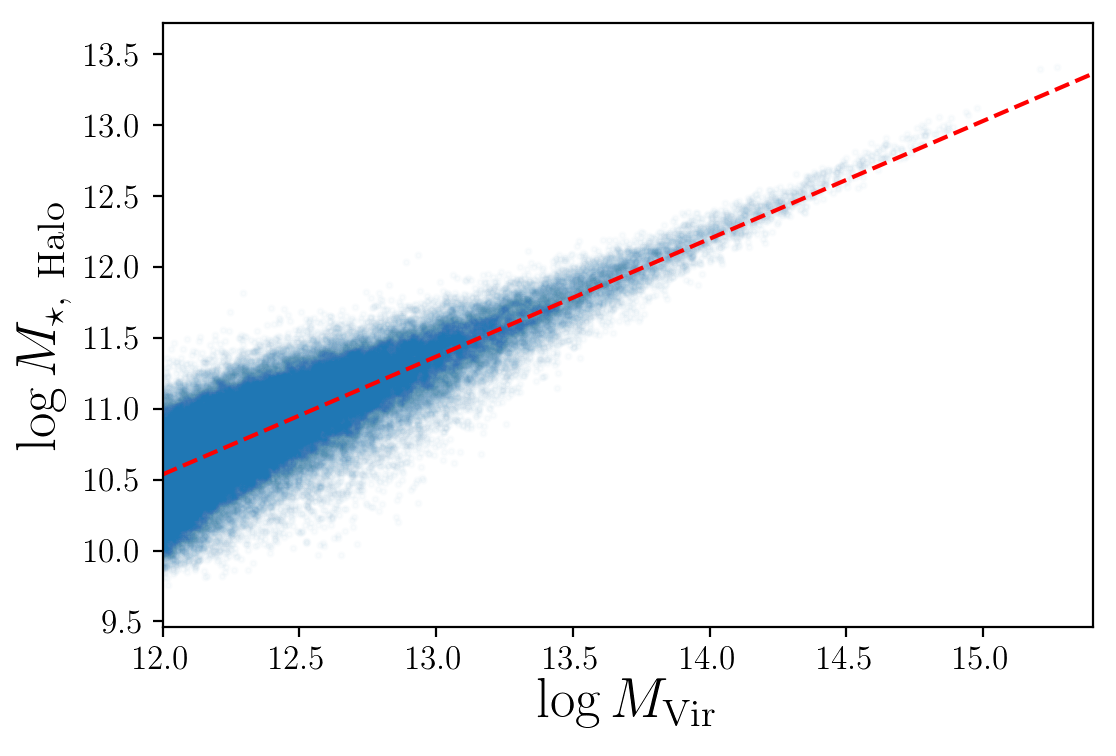

In [15]:
shmr_a, shmr_b = um.mockFitSimpleSHMR(um_min_mvir=12.8)

# Visualize the best-fit relation
mh_arr = np.linspace(12.0, 15.6, 50)
plt.scatter(um.um_mock['logmh_vir'][um.mask_central], 
            um.um_mock['logms_halo'][um.mask_central],
            s=4, alpha=0.02, rasterized=True);

plt.plot(mh_arr, (shmr_a * mh_arr + shmr_b), linestyle='--', 
         c='r');
plt.xlabel(r'$\log M_{\mathrm{Vir}}$', size=20); 
plt.ylabel(r'$\log M_{\star,\ \mathrm{Halo}}$', size=20);
plt.xlim(12.0, 15.4);

## Fit the UM Mhalo-(sigma Mstar) relation

# Mh-SigMs : Sig(logms_halo) = -0.0445 x logmh_vir + 0.7626


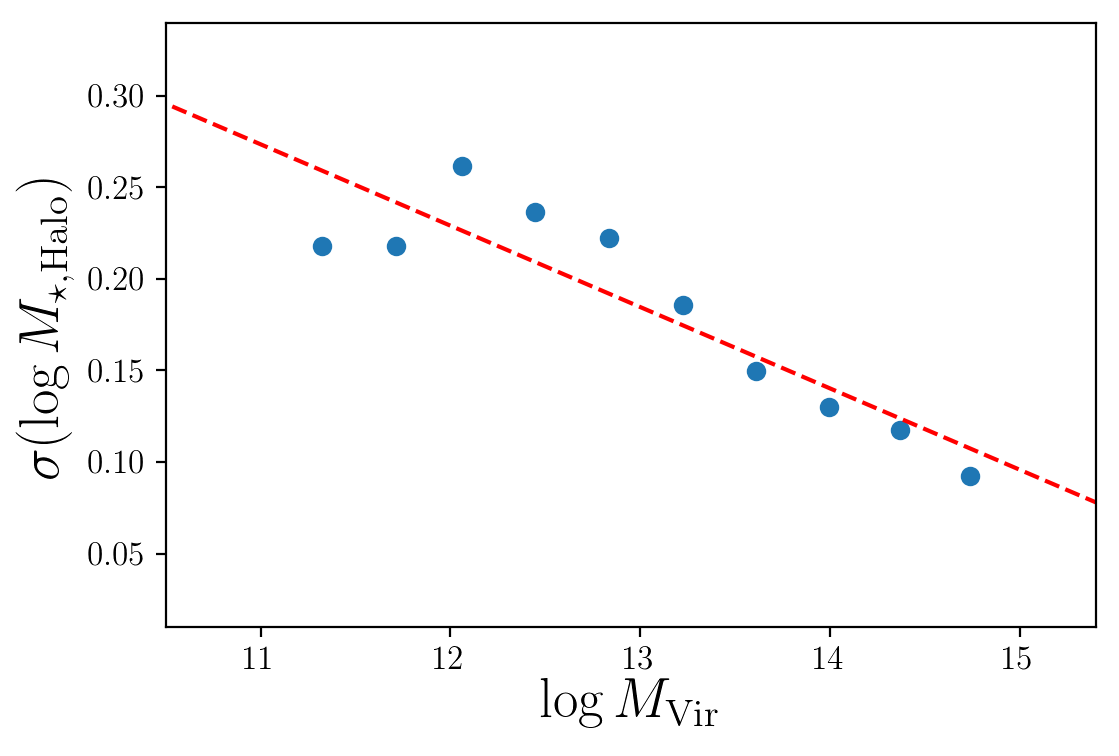

In [16]:
sigms_a, sigms_b, mh_bin, sig_bin = um.mockFitSimpleMhScatter(um_min_mvir=11.5)

# Visualize the results
mh_arr = np.linspace(10.0, 15.6, 50)
plt.scatter(mh_bin, sig_bin)
plt.plot(mh_arr, (sigms_a * mh_arr + sigms_b), 
         c='r', linestyle='--')

plt.xlabel(r'$\log M_{\mathrm{Vir}}$', size=20); 
plt.ylabel(r'$\sigma(\log M_{\star, \mathrm{Halo}})$', size=20);
plt.xlim(10.5, 15.4);
plt.ylim(0.01, 0.34);

## Estimate scatter based on a MHalo-Sig(Mstar) relation

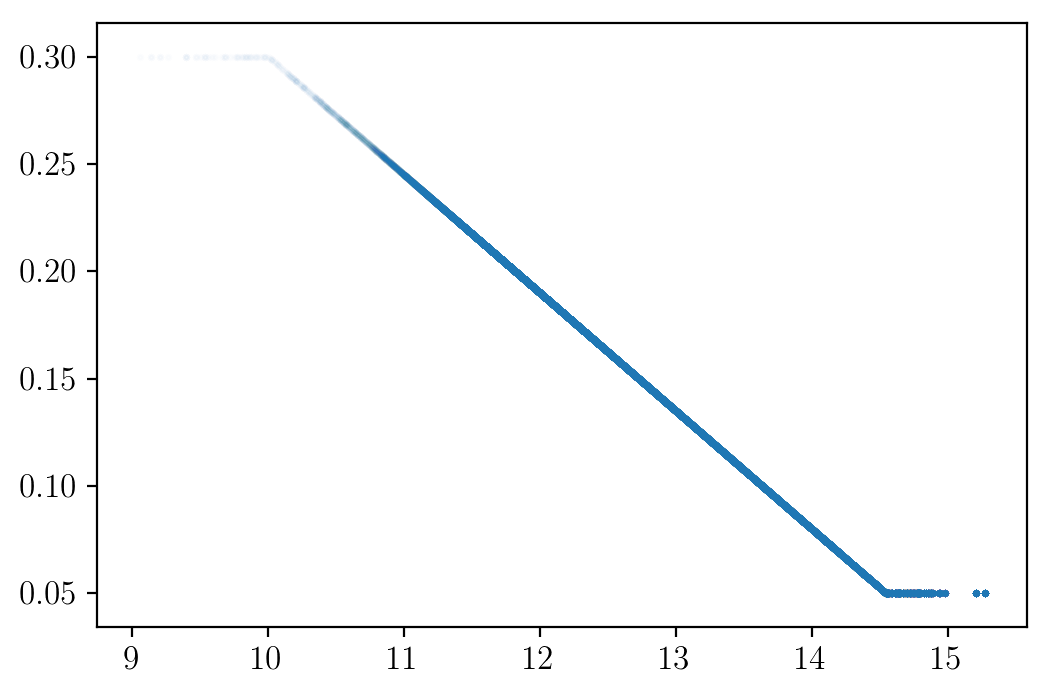

In [19]:
plt.scatter(um.um_mock['logmh_host'], 
            um.mockGetSimpleMhScatter(um.um_mock['logmh_host'], -0.055, 0.85, 
                                      min_scatter=0.05, max_scatter=0.3), 
             s=3, alpha=0.01);

## Pre-compute lensing pairs using UM mock catalog

In [100]:
mass_encl = um.umPreComputeWL(um.sim_halocat, 
                              wl_min_r=um.um_wl_minr,
                              wl_max_r=um.um_wl_maxr,
                              wl_n_bins=um.um_wl_nbin)

Total runtime for 312923 galaxies and 1.0e+06 particles =603.95 seconds


In [101]:
precompute_mass_binary = "Data/bolplanck_rockstar_halotools_v0p4_z0.0_precompute_20bins"

np.savez(precompute_mass_binary, 
         data=mass_encl)

## Predict M10 and M100 using UM model 

In [8]:
# Provide the model parameters
shmr_a, shmr_b = 0.829, 0.31
sigms_a, sigms_b = -0.04, 0.7

# Get the model predictions
um_mass_model = um.umPredictMass(shmr_a, shmr_b, sigms_a, sigms_b)
logms_mod_inn, logms_mod_tot, logms_mod_halo, mask_mtot = um_mass_model

# Only the models in the same range of the data will have M10 assigned
mask_m10_useful = (logms_mod_inn > 0.1)
print("# %d model galaxies have useful inner mass" % np.sum(mask_m10_useful))

um_smf_tot, um_smf_inn = um.umPredictSMF(logms_mod_tot, logms_mod_inn)  

um_wl_profs = um.umPredictWL(logms_mod_tot, logms_mod_inn, 
                             mask_mtot)

# 997 model galaxies have useful inner mass


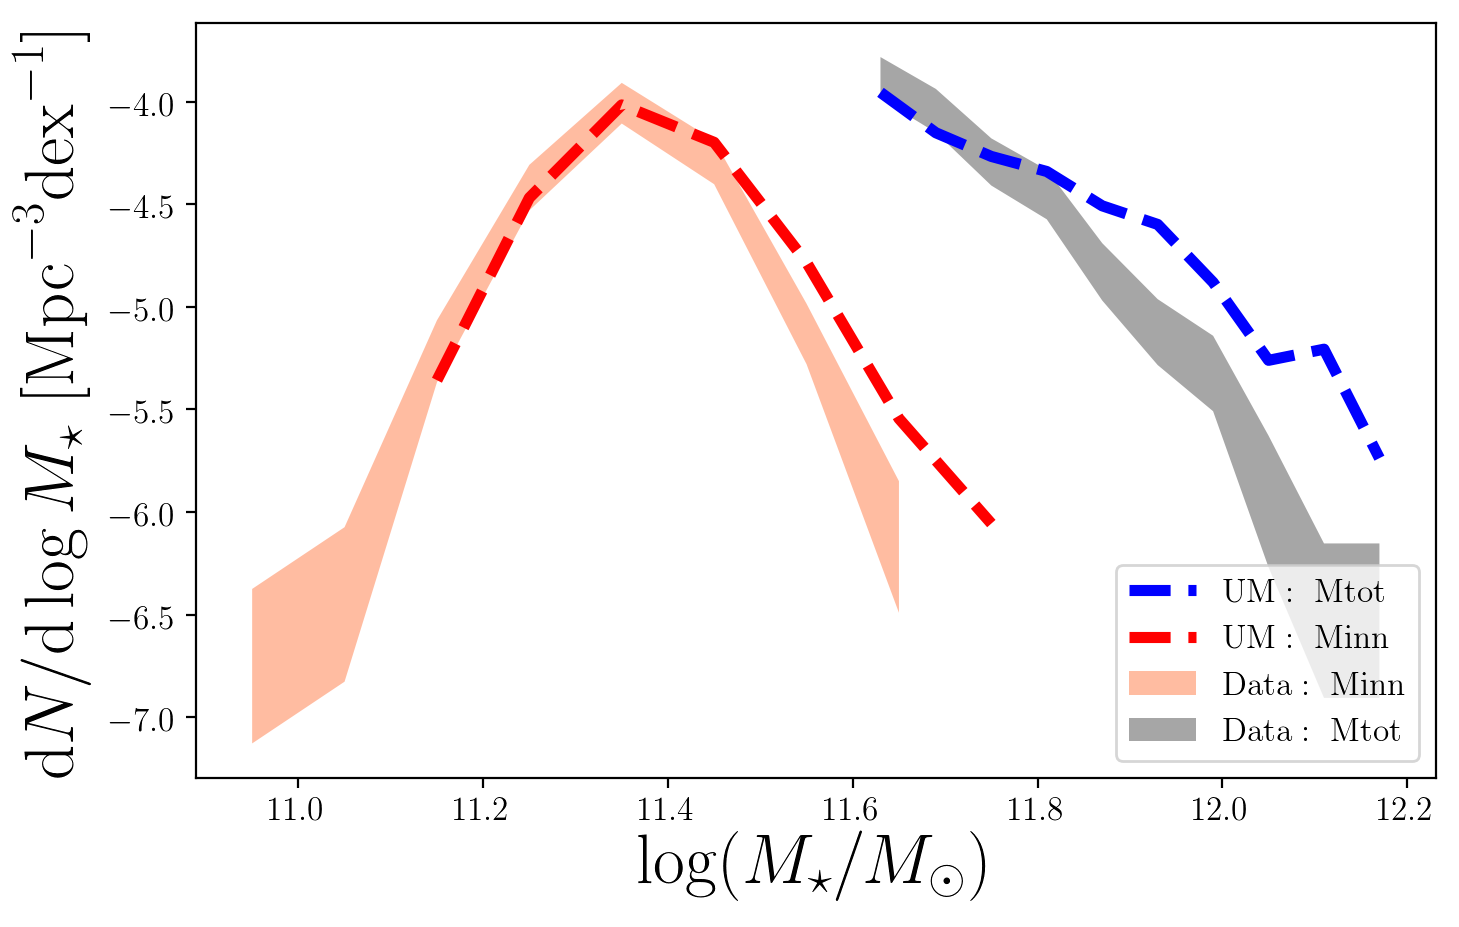

In [9]:
fig = plt.figure(figsize=(8, 5))

plt.fill_between(um.obs_smf_inn['logm_mean'],
                 np.log10(um.obs_smf_inn['smf_low']),
                 np.log10(um.obs_smf_inn['smf_upp']),
                 facecolor='lightsalmon',
                 edgecolor='none',
                 interpolate=True,
                 alpha=0.7, 
                 label=r'$\mathrm{Data:\ Minn}$')
#plt.plot(um.obs_smf_inn['logm_mean'],
#         np.log10(um.obs_smf_inn['smf']),
#         label=r'$\mathrm{M_inn}$',
#         linewidth=2, c='orangered')

plt.fill_between(um.obs_smf_tot['logm_mean'],
                 np.log10(um.obs_smf_tot['smf_low']),
                 np.log10(um.obs_smf_tot['smf_upp']),
                 facecolor='grey',
                 edgecolor='none',
                 interpolate=True, 
                 alpha=0.7,
                 label=r'$\mathrm{Data:\ Mtot}$')
#plt.plot(um.obs_smf_tot['logm_mean'],
#         np.log10(um.obs_smf_tot['smf']),
#         label=r'$\mathrm{M_tot}$',
#         linewidth=2, c='black')

plt.plot(um_smf_tot['logm_mean'], np.log10(um_smf_tot['smf']), 
         linewidth=4, linestyle='--', c='b',
         label=r'$\mathrm{UM:\ Mtot}$')

plt.plot(um_smf_inn['logm_mean'], np.log10(um_smf_inn['smf']), 
         linewidth=4, linestyle='--', c='r',
         label=r'$\mathrm{UM:\ Minn}$')

plt.legend()

plt.xlabel(r'$\log (M_{\star}/M_{\odot})$', 
           fontsize=25)
plt.ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
            r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
           size=25)

## Predict weak lensing profile using UM model

318


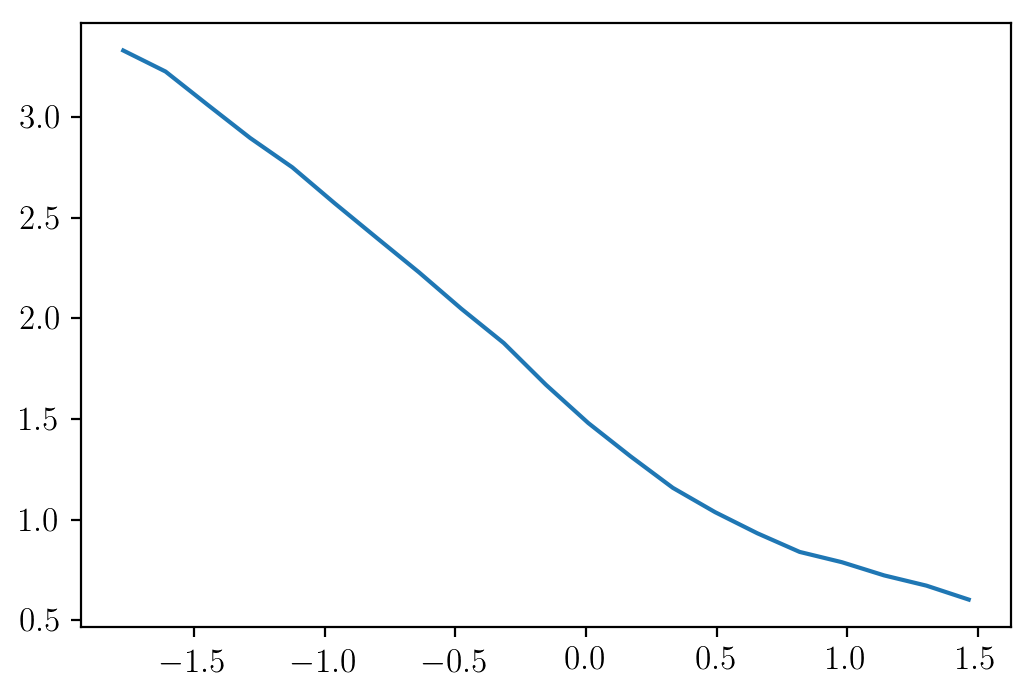

In [24]:
mask = ((um.um_mock['logms_tot'] > 11.80) & 
        (um.um_mock['logms_tot'] < 11.85))
print(np.sum(mask))

rp, dsigma = um.umGetWLProf(mask)

plt.plot(np.log10(rp), np.log10(dsigma))

## Generate model predictions all together

93.855564725


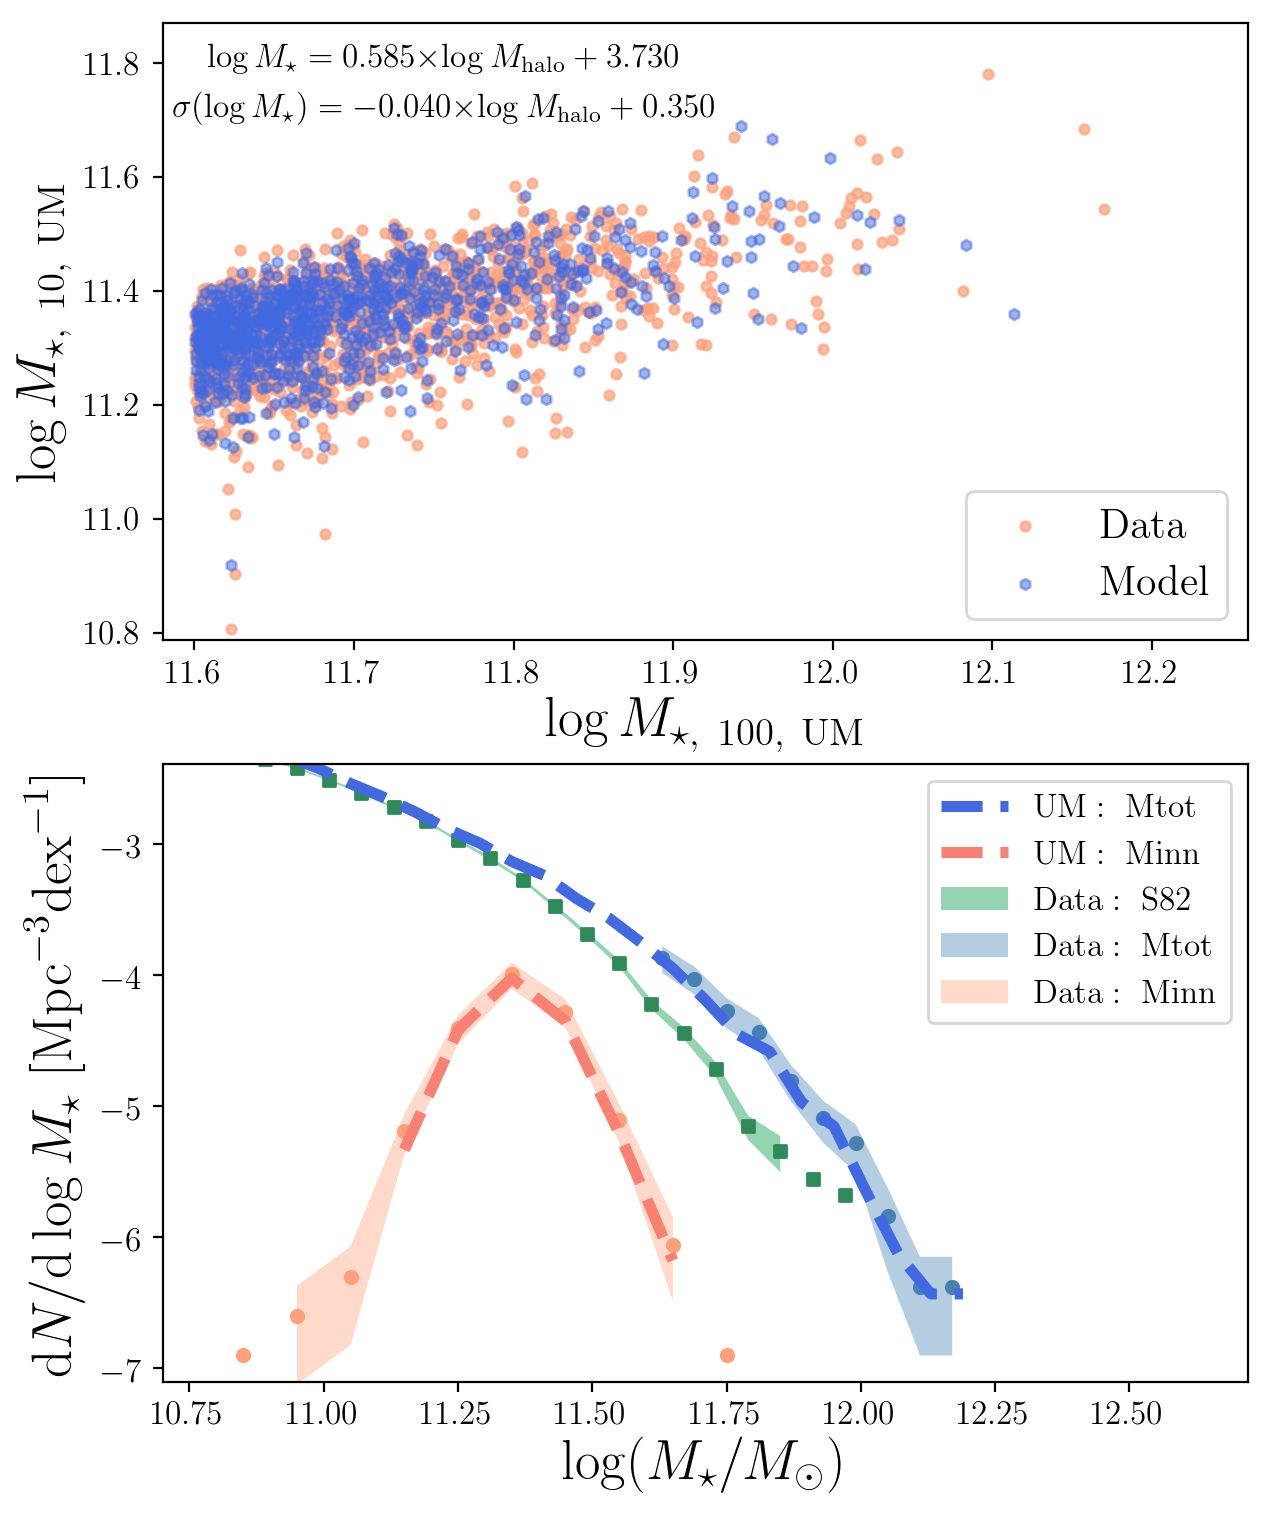

In [6]:
# Provide the model parameters
shmr_a, shmr_b = 0.585, 3.73
sigms_a, sigms_b = -0.04, 0.35

# Generate the model predictions
um_model = um.umPredictModel(shmr_a, shmr_b, sigms_a, sigms_b,
                             return_wl_mhalo=True)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_mod_inn, logms_mod_tot_all, mask_mtot) = um_model

logms_mod_tot = logms_mod_tot_all[mask_mtot]
um_smf_tot_all = um.computeSMF(logms_mod_tot_all,
                               um.um_volume,
                               30, 10.60, 12.4,
                               bootstrap=False)

# logM100-logM10 and SMF plot
fig1 = um.umPlotSMF(um_smf_tot_all, um_smf_inn, 
                    logms_mod_tot, logms_mod_inn,
                    shmr_a=shmr_a, shmr_b=shmr_b, 
                    sigms_a=sigms_a, sigms_b=sigms_b)

# Get the lnLikelihood
theta = (shmr_a, shmr_b, sigms_a, sigms_b)

lnlike_smf = um.lnLike(theta)
print(lnlike_smf)

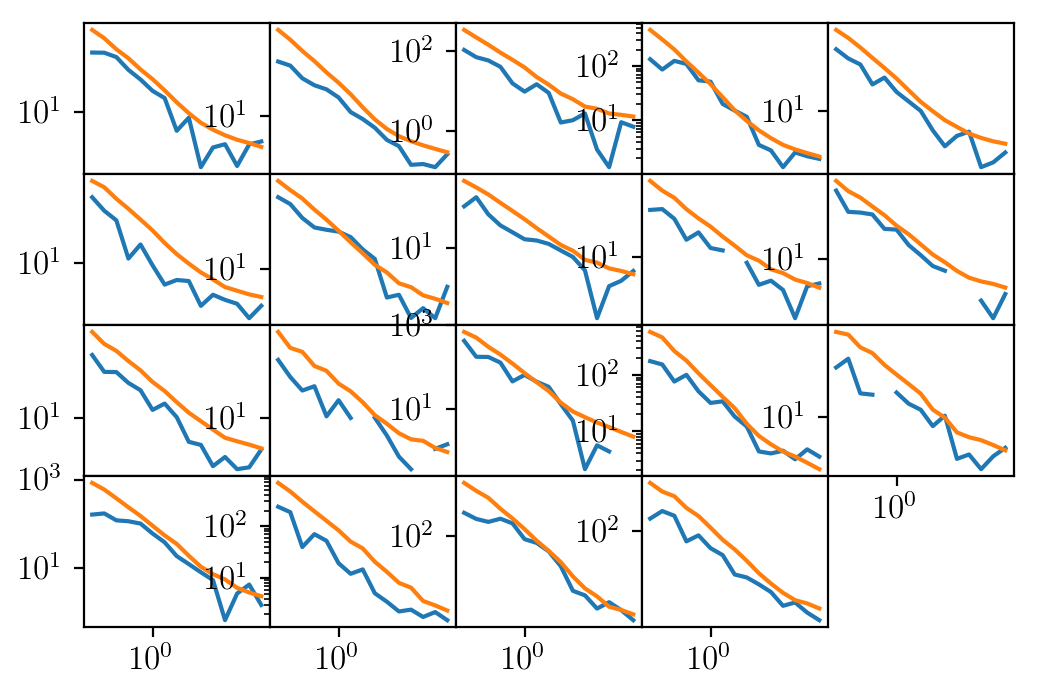

In [7]:
# WL profiles
fig2 = um.umPlotWL(um_wl_profs)

## Fit the model

In [8]:
kwargs = {'um_cat' : 'UM_bolshoi_mock_value_added.fits',
          'um_wlcat' : 'bolplanck_rockstar_halotools_v0p4_z0.0_precompute_20bins.npz',
          'obs_wl_sample' : 's16a_m100_m10_boxbin',
          'obs_smf_inn' : 's16a_massive_fastlane_logm10_smf_default.fits',
          'obs_smf_tot' : 's16a_massive_fastlane_logm100_smf_default.fits',
          'obs_smf_full' : 's82_total_smf_z0.15_0.43.fits',
          'mcmc_nsamples' : 150,
          'mcmc_nburnin' : 300,
          'mcmc_nwalkers' : 200,
          'obs_wl_calib' : 1.0,
          'mcmc_smf_only' : True,
          'mcmc_wl_only' : False,
          'mcmc_wl_weight' : 0.5
         }

um = UMMassProfModel(verbose=True, **kwargs)

# Input stellar mass catalog: s16a_wide_massive_fastlane_short_170610.fits
# Input weak lensing profile sample: s16a_m100_m10_boxbin
# There are 19 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: s16a_massive_fastlane_logm10_smf_default.fits
# Pre-computed SMF for total logMs: s16a_massive_fastlane_logm100_smf_default.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is     80672371.33 Mpc^3
# Using logm_10 as proxy of inner stellar mass.
# Using logm_100 as proxy of total stellar mass.
# For inner stellar mass: 
    16 bins at 10.40 < logMinn < 12.00
# For total stellar mass: 
    10 bins at 11.60 < logMtot < 12.20
# The volume of the UniverseMachine mock is     45553935.86 Mpc^3


In [9]:
um.mcmcFit()

# Setup the sampler ...
# Setup the initial guesses ...
# Phase: Burn-in ...


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# Phase: MCMC run ...
# Get MCMC samples and best-fit parameters ...
(0.59268305293807, 0.034578552809269469, 0.039241305252830982)
(3.616121283087991, 0.53766025218872393, 0.47505360935075736)
(-0.089683570047524669, 0.054179718480512146, 0.040854451809228198)
(0.58924394558162896, 0.51888218236353922, 0.46973701782266974)


93.7697260961


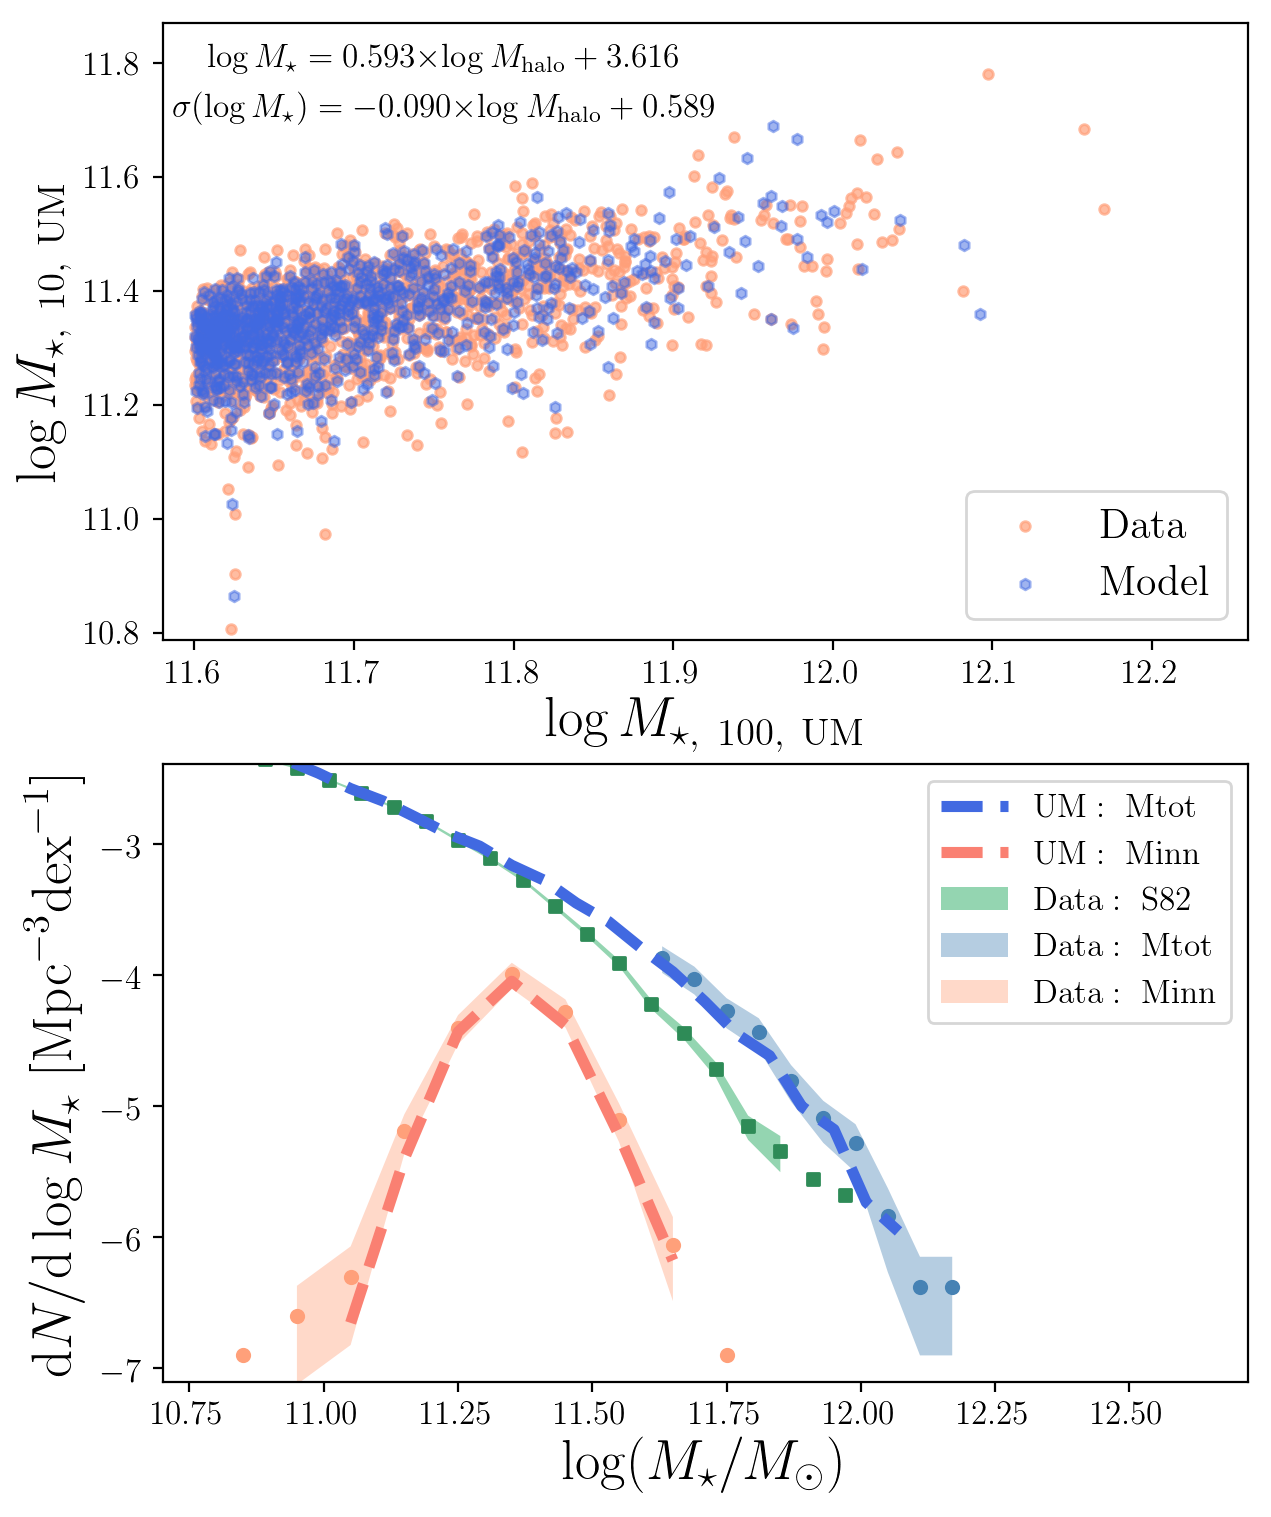

In [10]:
# Provide the model parameters
shmr_a, shmr_b = um.shmr_a_mcmc[0], um.shmr_b_mcmc[0]
sigms_a, sigms_b = um.sigms_a_mcmc[0], um.sigms_b_mcmc[0]

# Generate the model predictions
um_model = um.umPredictModel(shmr_a, shmr_b, sigms_a, sigms_b,
                             return_wl_mhalo=True)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_mod_inn, logms_mod_tot_all, mask_mtot) = um_model

logms_mod_tot = logms_mod_tot_all[mask_mtot]
um_smf_tot_all = um.computeSMF(logms_mod_tot_all,
                               um.um_volume,
                               30, 10.60, 12.4,
                               bootstrap=False)

um.umPlotSMF(um_smf_tot_all, um_smf_inn, 
             logms_mod_tot, logms_mod_inn,
             shmr_a=shmr_a, shmr_b=shmr_b, 
             sigms_a=sigms_a, sigms_b=sigms_b)

# Get the lnLikelihood
theta = (shmr_a, shmr_b, sigms_a, sigms_b)
lnlike_smf = um.lnLike(theta)
print(lnlike_smf)

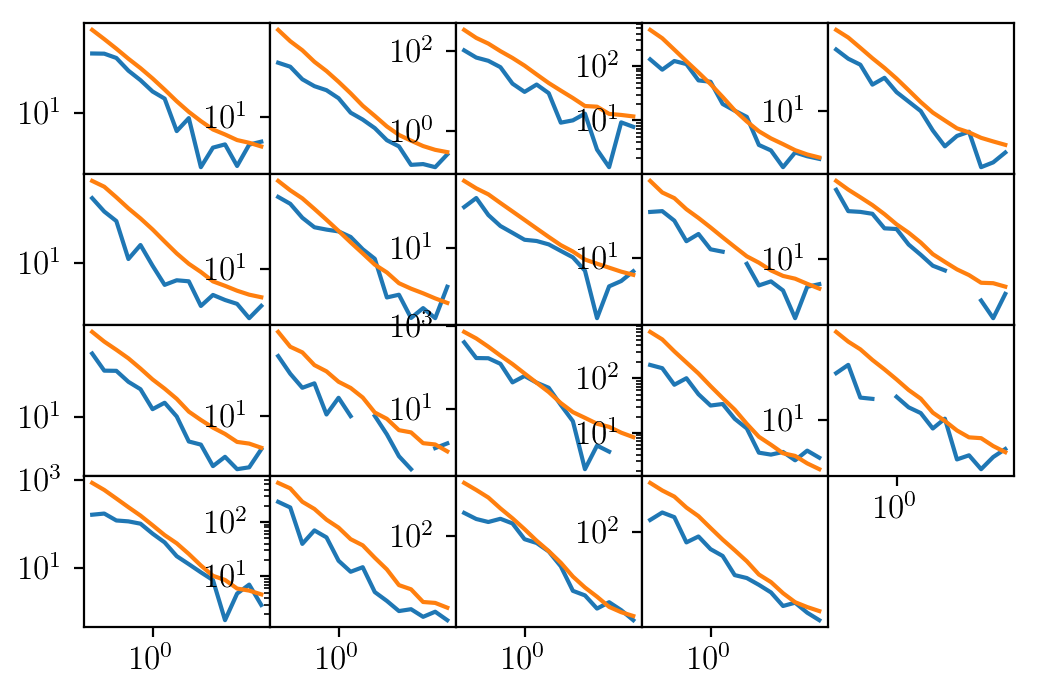

In [14]:
um.umPlotWL(um_wl_profs)

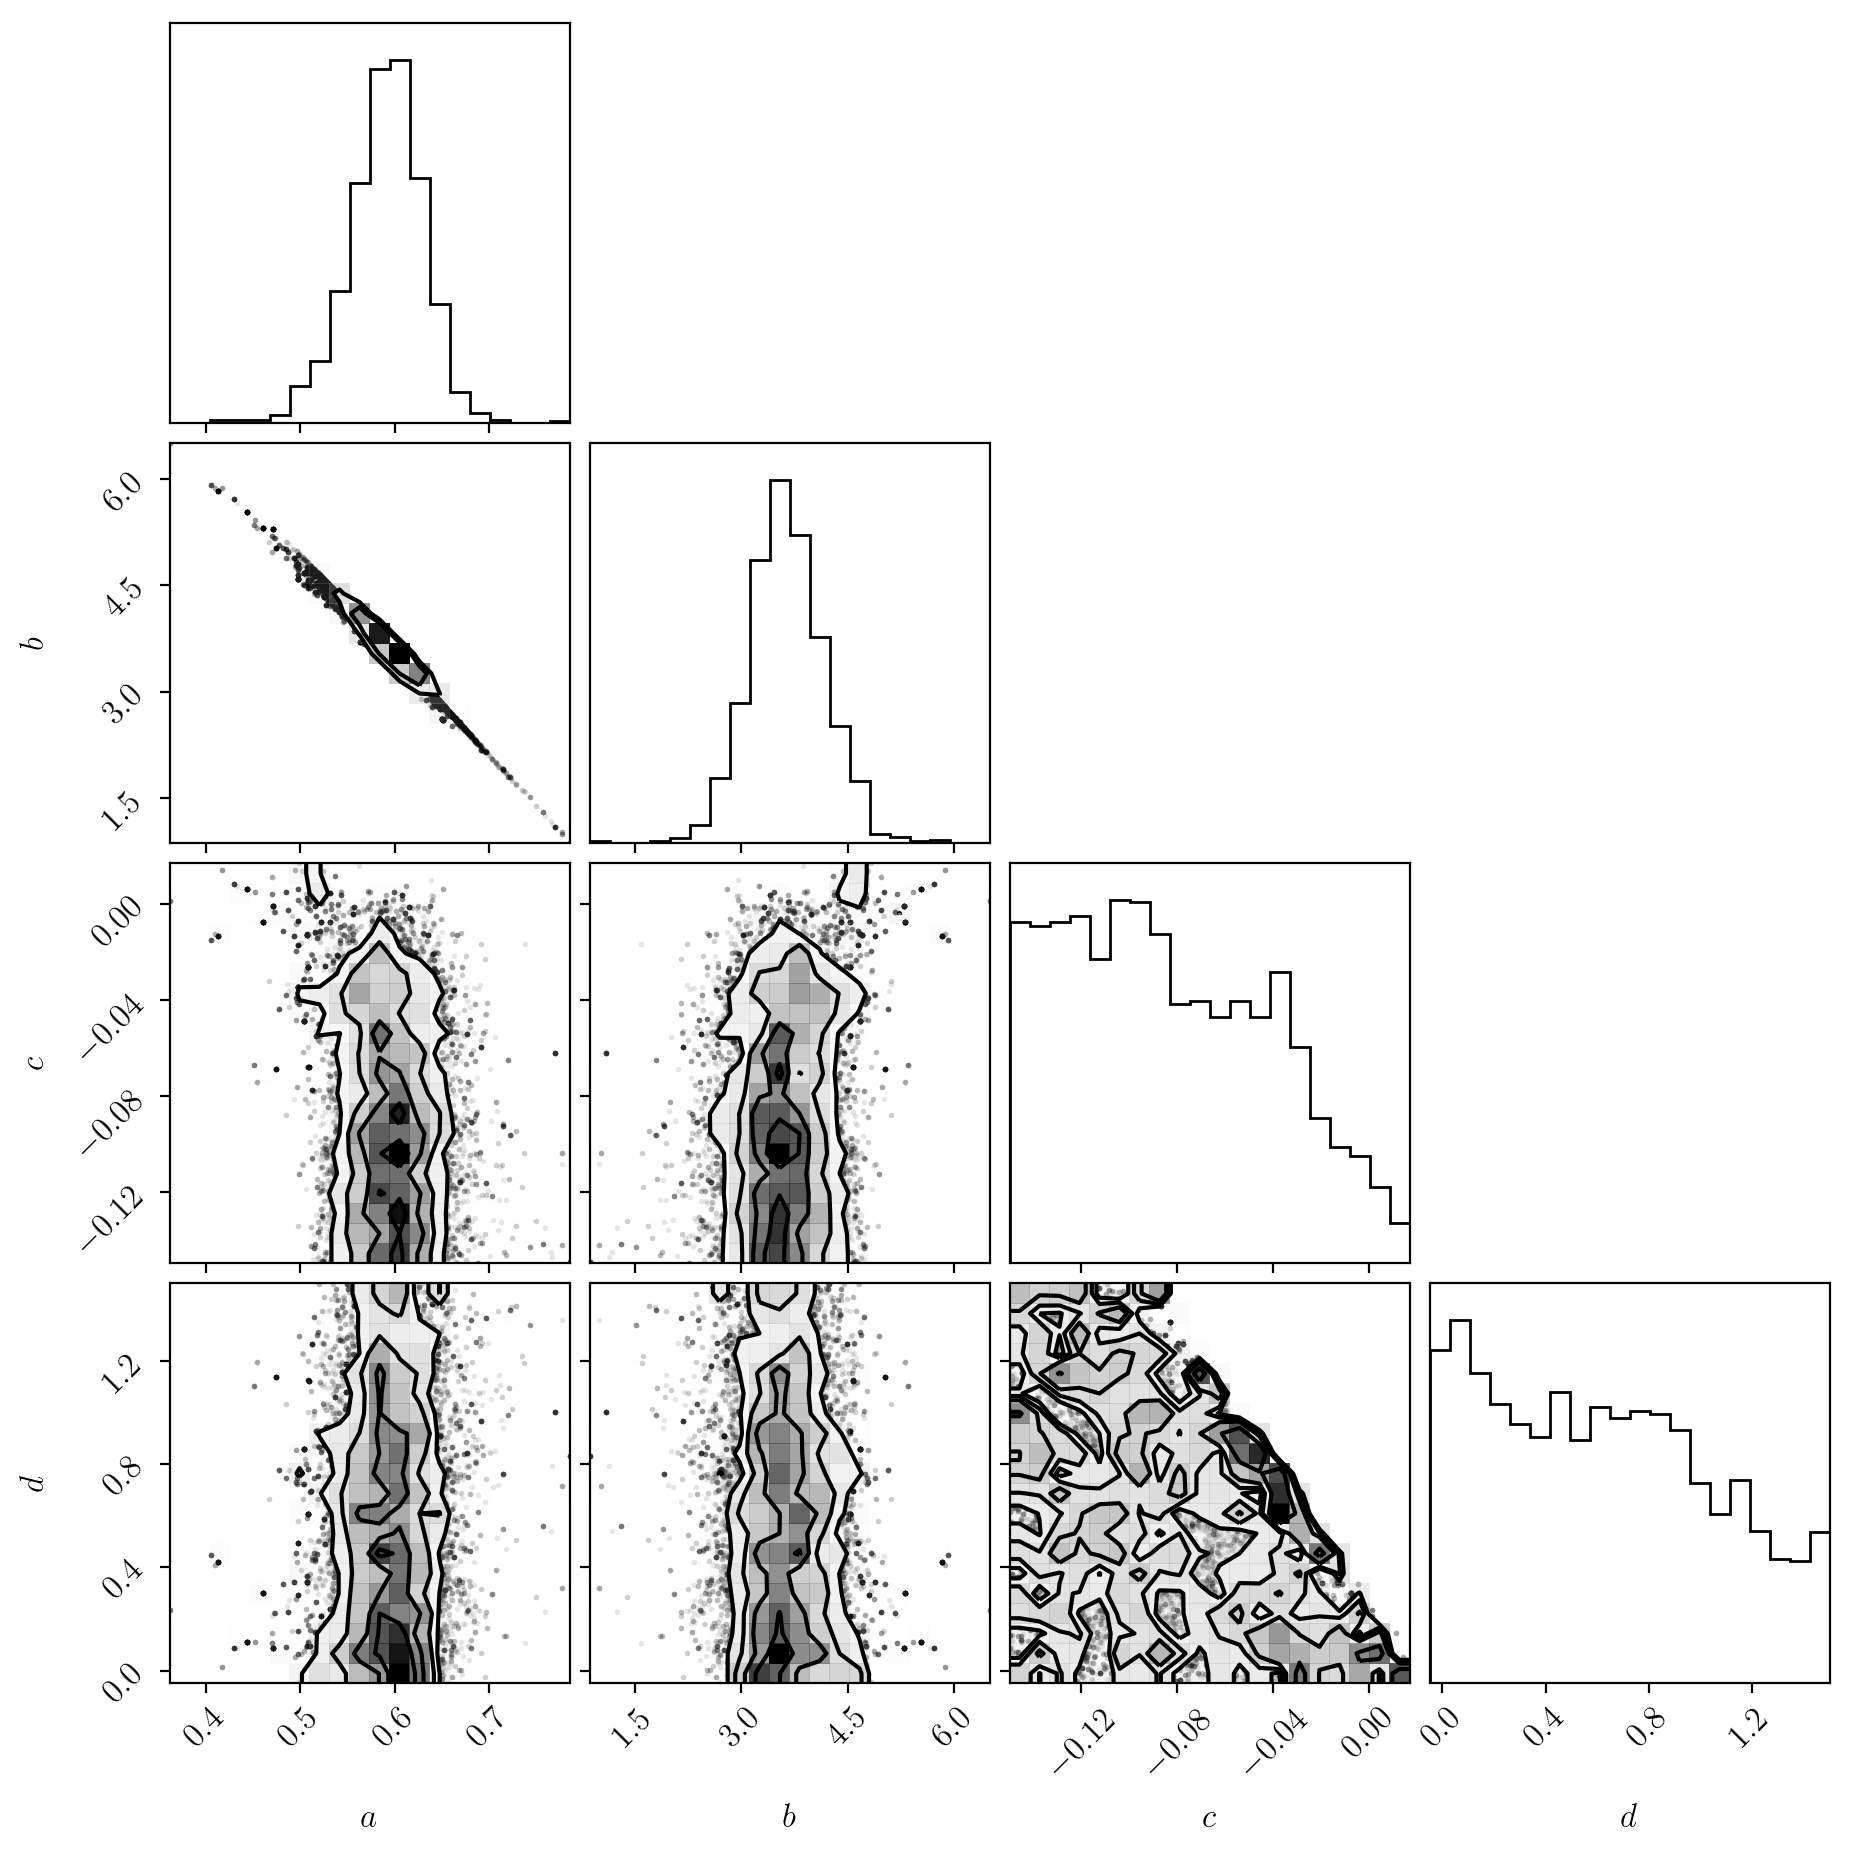

In [11]:
fig = corner.corner(um.mcmc_samples, 
                    labels=["$a$", "$b$", "$c$", "$d$"])

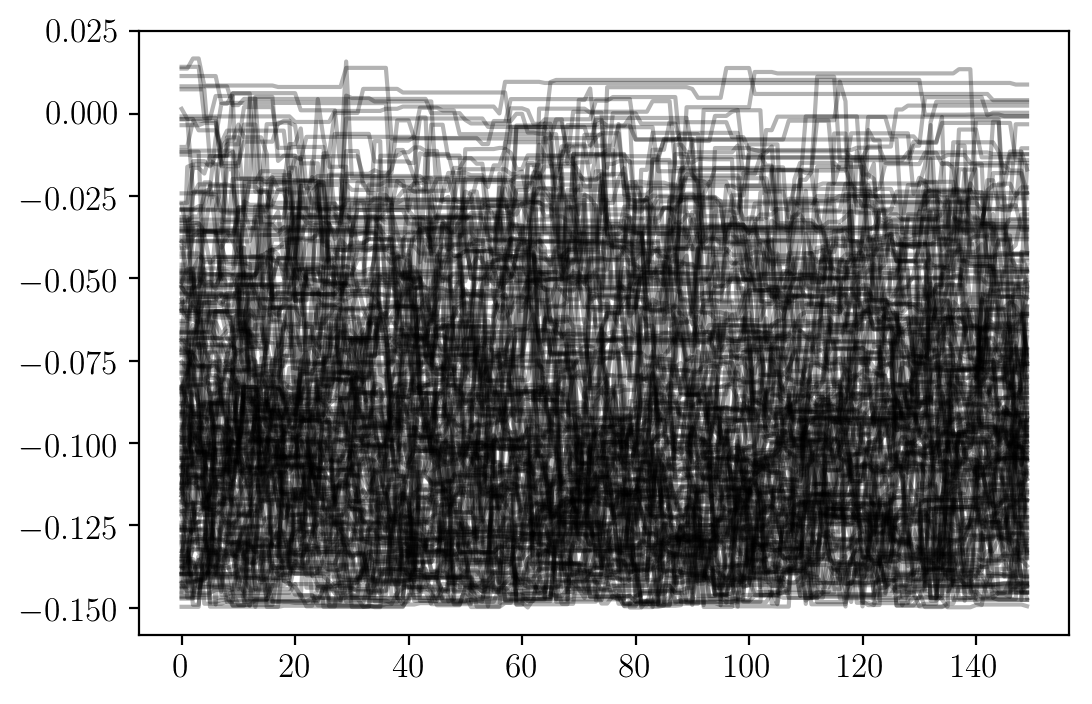

In [13]:
pp = plt.plot(um.mcmc_sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)

In [2]:
from astropy.cosmology import Planck15

kwargs = {'obs_wl_sample' : 's16a_m100_m10_boxbin',
          'obs_smf_inn' : 's16a_massive_fastlane_logm10_smf_default.fits',
          'obs_smf_tot' : 's16a_massive_fastlane_logm100_smf_default.fits',
          'obs_smf_full' : 's82_total_smf_z0.15_0.43.fits',
          'mcmc_nsamples' : 150,
          'mcmc_nburnin' : 300,
          'mcmc_nwalkers' : 200,
          'obs_wl_calib' : 1.0,
          'mcmc_smf_only' : True,
          'mcmc_wl_only' : False,
          'mcmc_wl_weight' : 0.5,
          'um_min_mvir' : 11.5,
          'sim_particle_mass' : 1.51E9, 
          'sim_num_ptcl_per_dim' : 3940,
          'sim_cosmos' : Planck15,
          'sim_particle_catalog' : 'Data/um2_mdpl2/mdpl2_particles_0.7333_10m.fits'
         }

um2 = UMMassProfModel(verbose=True, **kwargs)

# Input stellar mass catalog: s16a_wide_massive_fastlane_short_170610.fits
# Input weak lensing profile sample: s16a_m100_m10_boxbin
# There are 19 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: s16a_massive_fastlane_logm10_smf_default.fits
# Pre-computed SMF for total logMs: s16a_massive_fastlane_logm100_smf_default.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is     80672371.33 Mpc^3
# Using logm_10 as proxy of inner stellar mass.
# Using logm_100 as proxy of total stellar mass.
# For inner stellar mass: 
    16 bins at 10.40 < logMinn < 12.00
# For total stellar mass: 
    10 bins at 11.60 < logMtot < 12.20
# The volume of the UniverseMachine mock is   2915451895.04 Mpc^3
#-----------------------------------------------
#   Start to prepare the mock catalog 
#-----------------------------------------------
#   Start to pre-compute the lensing pairs 
# Using external partical table
#   The simulation particle mass 

In [3]:
um2.um_mock.write('Data/UM2_multidark_mock_value_added_mpeak_11.5.fits', format='fits', 
                  overwrite=True)

precompute_mass_binary = "Data/multidark_rockstar_halotools_v0p4_a0.7333_precompute_mpeak_11.5_20bins"

np.savez(precompute_mass_binary, data=um2.um_mass_encl)